## Example with Principal Component Analysis

- Dataset: chemical analysis determine the origin of wines
- https://archive.ics.uci.edu/ml/datasets/Wine

In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

In [301]:
def get_data(dir_name='data',class_label ='Class Label'):
    
    raw = pd.read_csv('{}/wine.csv'.format(dir_name),header=None)

    raw.columns = ['Class Label', 'Alcohol', 'Malic acid', 'Ash', 
    'Alcalinity of ash', 'Magnesium', 'Total phenols', 
    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
    'Color intensity', 'Hue', 'OD280/OD315 of Diluted Wines', 'Proline']
    
    print('Observations: ',raw.shape[0])
    print('Features: ',raw.shape[1])
    
    #Split data into features and class attribute
    x_cols = [c for c in raw.columns if class_label not in c]
    X = raw[x_cols]
    y = raw[class_label]
    
    return(X,y)

if __name__ == '__main__':

    X,y = get_data()

Observations:  178
Features:  14


**Feature**

In [302]:
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of Diluted Wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


**Class Labels Breakdown**

In [303]:
y.value_counts()

2    71
1    59
3    48
Name: Class Label, dtype: int64

**Split Data into Training and Testing**

In [245]:
def split_train_test(X,Y,train_size=0.80):
    
    """ Return Training/Testing Subsets"""
    
    idx = np.random.permutation(len(X))
    size = int(train_size*100)

    x_train = X[idx[:size]]
    y_train = Y[idx[:size]]
    
    x_test = X[idx[size:]]
    y_test = Y[idx[size:]]
    
    return(x_train,y_train,x_test,y_test)

if __name__ == '__main__':
    
    x_train,y_train,x_test,y_test = split_train_test(X.values,y.values)
    
    #Standardize
    x_train_std = StandardScaler().fit_transform(x_train)
    x_test_std = StandardScaler().fit_transform(x_test)

**Dimensionality Reduction**

1 Principal Component(s) -- Variance Explained: 0.346
2 Principal Component(s) -- Variance Explained: 0.190
3 Principal Component(s) -- Variance Explained: 0.119
4 Principal Component(s) -- Variance Explained: 0.085
5 Principal Component(s) -- Variance Explained: 0.067
6 Principal Component(s) -- Variance Explained: 0.049
7 Principal Component(s) -- Variance Explained: 0.037
8 Principal Component(s) -- Variance Explained: 0.007

** 8 Components Explains 0.900 of the Total Variance **

Sklearn -- 8 Principal Component(s) -- Variance Explained: 0.921


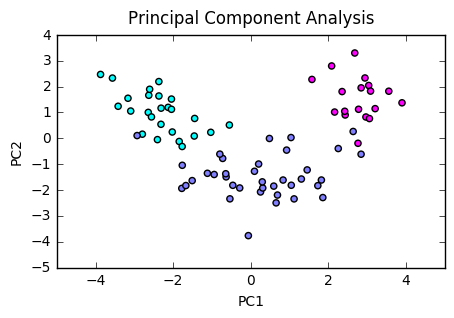

In [249]:
def do_PCA(X,y,n_components=8):
    
    #Compute Covariance Matrix
    mat = np.cov(X.T)

    #Eigenvalues and Eigenvectors
    eig_vals, eig_vect = np.linalg.eig(mat)
    
    eig_vals_r = eig_vals.T[:n_components]
    eig_vect_r = eig_vect.T[:n_components,:]
    
    #Compute Explained Variance
    var = sum(eig_vals)
    var_exp = [(i / var) for i in sorted(eig_vals_r, reverse=True)]

    for i in range(len(var_exp)):
        print('{0} Principal Component(s) -- Variance Explained: {1:.3f}'.format(i+1,var_exp[i]))

    #Cumulative Explained Variance
    cum_var_exp = np.cumsum(var_exp)
    print('\n** {0} Components Explains {1:.3f} of the Total Variance **'.format(len(var_exp),np.sum(var_exp)))
    
    #Projections
    proj = X.dot(eig_vect_r.T)
    pca_visual(proj,y)
    
    return(proj)

def do_PCA_sklearn(X,y,n_components=8):
    
    pc = PCA(n_components=n_components).fit(X)
    pcs = pc.transform(X)
    print('\nSklearn -- {0} Principal Component(s) -- Variance Explained: {1:.3f}'.format(n_components,np.sum(pc.explained_variance_ratio_)))
    return(pcs)

def pca_visual(proj,y):
    
    #Project Data onto Principal Components
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    ax.scatter(proj[:,0],proj[:,1],c=y,cmap='cool')
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
    ax.set_title('Principal Component Analysis',fontsize=12,y=1.02)


if __name__ == '__main__':
    
    pcs = do_PCA(x_train_std,y_train)
    pcs_sklearn = do_PCA_sklearn(x_train_std,y_train)

** Explore Decision Boundary for the First 2 Principal Components **

(177356, 2)


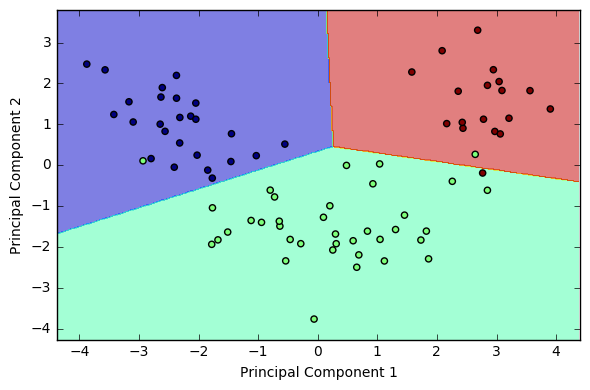

In [250]:
def plot_decision_regions(X,y,classifier,grid_res = 0.02):

    #Decision Surface
    x1_min, x1_max = X[:, 0].min() - .50, X[:, 0].max() + .50
    x2_min, x2_max = X[:, 1].min() - .50, X[:, 1].max() + .50
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, grid_res),
                           np.arange(x2_min, x2_max, grid_res))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    #Make Predictions given first 2 PCs
    print(np.array([xx1.ravel(), xx2.ravel()]).T.shape)
    
    Z = Z.reshape(xx1.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    #Countour Plot
    plt.contourf(xx1,xx2,Z,alpha=0.50,cmap='jet')
    
    plt.xlim(x1_min,x1_max)
    plt.ylim(x2_min,x2_max)
    
    #Plot Datapoints
    plt.scatter(X[:,0],X[:,1],c=y,cmap='jet')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower left')
    plt.tight_layout()
    
if __name__ == '__main__':
    pcs_r = pcs[:,:2]
    lr = LogisticRegression()
    lr = lr.fit(pcs_r, y_train)
    plot_decision_regions(pcs,y_train,classifier=lr)

### Pipeline w/out Gridearch

In [430]:
def make_pipeline(n_components=4,solver='randomized'):
    
    pipe_RF = Pipeline(
        [('pca',PCA(n_components=n_components,svd_solver=solver)),
         ('RandomForest',RandomForestClassifier(n_estimators=100,n_jobs=3))])
    
    pipe_LR = Pipeline(
        [('pca',PCA(n_components=n_components,svd_solver=solver)),
         ('LogisticRegression',LogisticRegression())])
    
    return(pipe_RF,pipe_LR)

def pipeline_(X,y,n_splits=10):
    
    results = pd.DataFrame(columns=['Model','Precision','Recall','F1','Accuracy'])
    clf_pipes = make_pipeline()
    
    #Stratified KFold
    cv = StratifiedKFold(n_splits=n_splits)

    for clf in clf_pipes:

        model = clf.steps[1][0]
        print('================ Model: {} ================ '.format(model))

        accuracy_results = []
        
        #Train/Test Model
        for fold, (train,test) in enumerate(cv.split(X,y)):

            clf.fit(X.ix[train,:],y[train])
            y_pred = clf.predict(X.ix[test,:])
            
            #Compute Summary Statistics
            p,r,f1,_= precision_recall_fscore_support(y_pred,y[test],average='weighted')
            
            acc = accuracy_score(y_pred,y[test])
            accuracy_results.append(acc)
            print('Fold {0} -- Accuracy {1:.3f}'.format(fold+1,acc))
            
            #Append results to DataFrame
            results = results.append({
              'Fold': fold+1,
              'Model':model,
              'Precision':p,
              'Recall':r,
              'F1':f1,
              'Accuracy': acc},ignore_index=True)
            
        print('Average Training Accuracy: {0} +- {1:.3f}'.format(np.mean(accuracy_results)*100,np.std(accuracy_results)*100))

    return(results)

if __name__ == '__main__':
    
    results = pipeline_(X,y)

================ Model: RandomForest ================ 
Fold 1 -- Accuracy 0.895
Fold 2 -- Accuracy 0.833
Fold 3 -- Accuracy 0.833
Fold 4 -- Accuracy 0.833
Fold 5 -- Accuracy 0.889
Fold 6 -- Accuracy 0.889
Fold 7 -- Accuracy 1.000
Fold 8 -- Accuracy 0.944
Fold 9 -- Accuracy 1.000
Fold 10 -- Accuracy 1.000
Average Training Accuracy: 91.16959064327486 +- 6.649
================ Model: LogisticRegression ================ 
Fold 1 -- Accuracy 0.842
Fold 2 -- Accuracy 0.889
Fold 3 -- Accuracy 0.889
Fold 4 -- Accuracy 0.889
Fold 5 -- Accuracy 0.889
Fold 6 -- Accuracy 0.944
Fold 7 -- Accuracy 1.000
Fold 8 -- Accuracy 0.944
Fold 9 -- Accuracy 0.941
Fold 10 -- Accuracy 1.000
Average Training Accuracy: 92.27726178190574 +- 4.930


In [391]:
results.head()

,Model,Precision,Recall,F1,Accuracy,Fold
0,Random Forest,0.914035,0.894737,0.894205,0.894737,1.0
1,Random Forest,0.860317,0.833333,0.834894,0.833333,2.0
2,Random Forest,0.955556,0.777778,0.836971,0.777778,3.0
3,Random Forest,0.833333,0.833333,0.833333,0.833333,4.0
4,Random Forest,0.925926,0.888889,0.893056,0.888889,5.0


### Pipeline w/ Gridearch

In [582]:
def get_params():
    
    #PC components 
    components = [5,8,10]
    
    #Random Forest
    RF_params = dict(pca__n_components=components,RandomForest__n_estimators=[100,250,500])

    #Logistic Regression
    LR_params = dict(pca__n_components=components)    
    
    return(RF_params,LR_params)

def pipeline_gridsearch_(X,y):
    
    results = defaultdict()
    
    clf_pipes = [(clf,params) for clf,params in zip(make_pipeline(),get_params())]
    for clf in clf_pipes:
        
        model = clf[0].steps[1][0]
        print('================ Model: {} ================ '.format(model))
        
        clf = GridSearchCV(clf[0],param_grid=clf[1],cv=10,scoring='accuracy')
        clf.fit(X,y)
        
        print('Fold {0} -- Max Cross Validation Score of {1:.3f}'.format(clf.best_index_,clf.best_score_*100))
        print('Mean Test Score: {0:.3f} +- {1:.3f}'.format(float(np.mean(clf.cv_results_['mean_test_score'])*100),
                                            float(np.mean(clf.cv_results_['std_test_score'])*100)))

        #Cross-Validation Keys of Interest:
        k_cv = clf.cv_results_
        filt = ['std_score_time','mean_fit_time','mean_train_score','mean_test_score','param_pca__n_components']
        
        filtered_cv = dict((k, k_cv[k]) for k in filt if k in k_cv)
        results[model] = filtered_cv
        
    return(results)
        
if __name__ == '__main__':
    
    results = pipeline_gridsearch_(X,y)

================ Model: RandomForest ================ 
Fold 7 -- Max Cross Validation Score of 96.067
Mean Test Score: 94.070 +- 5.543
================ Model: LogisticRegression ================ 
Fold 2 -- Max Cross Validation Score of 96.629
Mean Test Score: 95.693 +- 4.223
